# Challenge Quilmes
#### Fábio Negreiros Ribeiro

#

El objetivo de este desafío es impulsar las ventas de la _Cervecería y Maltería Qilmes_. Para esto, en un primer paso sus clientes que ganan un crédito de la empresa van a ser evaluados en términos de cuánto lo usan y si lo pagan sin o con muy poco atraso. Además, se construirá un modelo de forma de predecir cuáles, de los clientes que no tienen crédito, deberían ganar uno.

Empezamos cargando algunas bibliotecas comunes y las tablas proporcionadas en el desafío.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_tr = pd.read_csv("transacciones - transacciones.csv")
df_lp = pd.read_csv("limitesyplazos - limitesyplazos.csv")
df_c = pd.read_csv("clientes - clientes.csv")
df_d = pd.read_csv("deuda - deuda.csv")

# Consideraciones generales

Empezamos con la tabla de los clientes, la más básica de las 4. Descubriendo cuántos clientes hay.

In [3]:
len(df_c.id_cliente.unique())

42995

Son 42995 clientes distintos. Vamos a extraer del dataset la característica "cliente hace X meses", o la _edad_ del cliente, que puede ser importante para determinar si un cliente es bueno o no.

In [4]:
df_c['fecha']=pd.to_datetime(df_c.mes_alta)

In [5]:
today = pd.to_datetime("today")
df_c['meses_cliente']=((today - df_c.fecha)/np.timedelta64(1, 'M')).astype(int)

In [6]:
df_c=df_c.drop(columns=['mes_alta','fecha'])
df_c

,id_cliente,subcanal,meses_cliente
0,3823,C,213
1,5813,C,213
2,5999,C,213
3,8425,B,262
4,9993,D,289
...,...,...,...
42990,1930591,A,192
42991,1978155,C,187
42992,1979465,C,182
42993,1980115,C,180


Guardamos para después estos datos.

In [7]:
df_c=df_c.set_index('id_cliente')
df_c

,subcanal,meses_cliente
id_cliente,,
3823,C,213
5813,C,213
5999,C,213
8425,B,262
9993,D,289
...,...,...
1930591,A,192
1978155,C,187
1979465,C,182


# Objetivo 1: A qué clientes otorgar más crédito

Empezamos analizando cuántos clientes potencialmente tienen crédito mirando la información en el archivo "limitesyplazos - limitesyplazos.csv".

In [8]:
lista_clientes_credito = df_lp.id_cliente.unique()
print(len(lista_clientes_credito))

904


Son 904 clientes con crédito. Vamos a crear un dataset con los datos de transacciones de los clientes con crédito.

In [9]:
df_cl_cred = df_tr[df_tr.id_cliente.isin(lista_clientes_credito)]

Una de las características de los mejores clientes es el uso del límite disponible. Vamos a juntar entonces la tabla de los clientes con crédito "df_cl_cred" con la tabla "df_lp", que contiene los límites por cliente y por fecha.

In [10]:
df_cl_cred = df_cl_cred.merge(df_lp, on=['id_cliente','mes'], how='left')

Vemos que ganamos muchos datos nulos (_NAN_). Vamos a ver el valor de las compras por crédito para estos casos.

In [11]:
df_cl_cred[ df_cl_cred.limite_maximo.isna() ]

,id_cliente,mes,compras_contado,compras_credito,compras_total,n_compras_total,n_sucursales,limite_maximo,plazo_maximo,limite_findemes,plazo_findemes
0,8425,2020-09-01,43691.96,0.0,43691.96,20,1,NaN,NaN,NaN,NaN
1,8425,2020-10-01,31498.67,0.0,31498.67,12,1,NaN,NaN,NaN,NaN
2,8425,2020-11-01,7278.77,0.0,7278.77,8,1,NaN,NaN,NaN,NaN
3,8425,2020-12-01,18265.03,0.0,18265.03,9,1,NaN,NaN,NaN,NaN
4,8425,2021-01-01,83760.52,0.0,83760.52,15,1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
19836,1739923,2021-11-01,0.00,0.0,0.00,0,0,NaN,NaN,NaN,NaN
19837,1739923,2021-12-01,0.00,0.0,0.00,0,0,NaN,NaN,NaN,NaN
19838,1739923,2022-01-01,0.00,0.0,0.00,0,0,NaN,NaN,NaN,NaN
19839,1739923,2022-02-01,2210.53,0.0,2210.53,2,1,NaN,NaN,NaN,NaN


O sea, hay meses sin la información del límite máximo, pero que igual el cliente usó el crédito. Esto tiene que ser arreglado de alguna forma.

Vamos a considerar primero la hipótesis que si no hay información sobre el límite disponible de un cliente y al mismo tiempo el cliente no usó el crédito, es porque no tenía todavía este serivicio a su disposición. Por lo tanto, vamos a remover los datos donde "compras_credito" es cero y el "limite_maximo" es nulo ("NAN").

In [12]:
df_null = df_cl_cred[ df_cl_cred.limite_maximo.isna() ]
indices_to_remove = df_null[df_null.compras_credito == 0].index

In [13]:
df_cl_cred.drop(index=indices_to_remove,inplace=True)

Esto soluciona parte del problema. Hay ahora los meses donde el cliente usó el crédito pero no hay información respecto a los límites. Vamos a reemplazar, para cada cliente, los datos nulos con el límite medio entre los puntos con datos más próximos.

In [14]:
val_limb = df_cl_cred.groupby(by='id_cliente')['limite_maximo'].transform('bfill') # Backward-fill
val_limf = df_cl_cred.groupby(by='id_cliente')['limite_maximo'].transform('ffill') # Forward-fill
val_lim=0.5*(val_limb+val_limf) # Average of back/forward fill
df_cl_cred.limite_maximo.fillna(value=val_lim,inplace=True)

Para el plazo máximo, se considera la media.

In [15]:
val_pl = df_cl_cred.groupby(by='id_cliente')['plazo_maximo'].transform('mean')
df_cl_cred.plazo_maximo.fillna(value=val_pl,inplace=True)

Para los límites y plazos de fin de mes, analizamos en cuántos casos ellos son distintos de los valores máximos en más de 10%.

In [16]:
comparacion = df_cl_cred.groupby(by='id_cliente')[['limite_maximo','plazo_maximo','limite_findemes','plazo_findemes']].mean()
comparacion[(np.abs(comparacion.limite_maximo - comparacion.limite_findemes) > comparacion.limite_maximo/10)]

,limite_maximo,plazo_maximo,limite_findemes,plazo_findemes
id_cliente,,,,
409827,49000.000000,21.000000,42875.000000,21.000000
1600385,3045.454545,21.727273,2727.272727,21.136364
1637305,10000.000000,21.333333,8750.000000,19.166667
1637537,14115.384615,25.500000,11583.333333,24.750000
1648833,8333.333333,30.000000,6666.666667,30.000000
1733341,25630.000000,15.000000,19675.000000,15.000000
1733697,40000.000000,30.000000,32500.000000,26.750000
1739881,3500.000000,15.000000,2625.000000,15.000000


In [17]:
comparacion[(np.abs(comparacion.plazo_maximo - comparacion.plazo_findemes) > comparacion.plazo_maximo/10)]

,limite_maximo,plazo_maximo,limite_findemes,plazo_findemes
id_cliente,,,,
1204743,29703.730000,133.666667,29703.730000,75.333333
1243267,10999.841818,78.636364,10999.841818,62.727273
1244535,10150.000000,85.000000,10150.000000,67.500000
1287163,36272.727273,78.636364,36272.727273,62.727273
1293157,17022.727273,78.636364,17409.090909,62.727273
1637305,10000.000000,21.333333,8750.000000,19.166667
1650465,10397.727273,65.714286,10357.142857,49.047619
1675019,12627.272727,78.636364,12627.272727,62.727273
1695625,10000.000000,85.000000,10000.000000,67.500000


Vemos que son muy pocos casos donde haya una diferencia significativa entre estos valores. Para simplificar el modelo, vamos desconsiderar estas informaciones.

In [18]:
df_cl_cred.drop(columns=['limite_findemes','plazo_findemes'],inplace=True)

Nuestra tabla con los créditos de cada cliente se ve así.

In [19]:
df_cl_cred

,id_cliente,mes,compras_contado,compras_credito,compras_total,n_compras_total,n_sucursales,limite_maximo,plazo_maximo
8,8425,2021-05-01,4447.75,2608.54,7056.29,9,1,10000.0,21.0
9,8425,2021-06-01,8621.18,0.00,8621.18,6,1,10000.0,21.0
10,8425,2021-07-01,28361.71,0.00,28361.71,13,1,10000.0,21.0
22,10231,2020-09-01,0.00,0.00,0.00,0,0,1000.0,15.0
23,10231,2020-10-01,0.00,0.00,0.00,0,0,1000.0,15.0
...,...,...,...,...,...,...,...,...,...
19883,1980467,2022-02-01,0.00,0.00,0.00,0,0,1500.0,15.0
19884,1980467,2022-03-01,0.00,0.00,0.00,0,0,750.0,15.0
19885,1980467,2022-04-01,0.00,0.00,0.00,0,0,375.0,15.0
19886,1980467,2022-05-01,0.00,0.00,0.00,0,0,187.0,15.0


La columna "mes" no aporta nada más, dado que ya la usamos para filtrar y ordenar. 

In [20]:
df_cl_cred.drop(columns=['mes'],inplace=True)

Vamos a calcular una nueva característica, el valor del crédito normalizado por el límite máximo, que nos da cuánto del límite, en porcentaje, fue utilizado durante cada mes. Este valor puede ser más grande que 1 por razones ya explicadas en la información de este Challenge.

In [21]:
df_cl_cred['porcent_lim'] = df_cl_cred['compras_credito'] / df_cl_cred['limite_maximo']

Vamos a calcular también el porcentaje del valor de compras de contado en relación a las compras totales.

In [22]:
df_cl_cred['porcent_cont'] = df_cl_cred['compras_contado'] / (df_cl_cred['compras_total']+.01)

Finalmente, calcularemos para cada cliente:

    1. El total de compras de contado, sumando todos los meses; 
    
    2. El número de compras medio por mes;
    
    3. El número medio de sucursales durante el periodo;
    
    4. La media del porcentaje de uso del crédito;
    
    5. El desvío _standard_ de la media del porcentaje de uso del crédito.

In [23]:
df_cl_info = df_cl_cred.groupby(by='id_cliente').agg( { 'compras_total':'sum',
                                                        'n_compras_total':'mean',
                                                        'n_sucursales':'mean',
                                                        'porcent_lim':['mean','std'],
                                                       } )

In [24]:
df_cl_info.columns = ['total_compras','n_compras_medio','n_sucursales_medio',
                      'porc_lim_por_mes','porc_lim_por_mes_dev']

In [25]:
df_cl_info

,total_compras,n_compras_medio,n_sucursales_medio,porc_lim_por_mes,porc_lim_por_mes_dev
id_cliente,,,,,
8425,44039.18,9.333333,1.000000,0.086951,0.150604
10231,16460.50,3.000000,0.863636,0.512016,0.414910
10865,4877970.52,10.454545,2.000000,0.388556,0.132607
11447,843637.95,7.090909,1.000000,1.022081,0.546682
12745,492283.57,3.000000,1.181818,1.072680,0.403384
...,...,...,...,...,...
1739895,1046181.99,8.000000,1.000000,0.700095,0.038367
1739921,22893.64,1.500000,0.500000,0.000000,NaN
1739923,14102.55,2.750000,1.000000,1.726591,0.167712


Tenemos información de 904 clientes que usaron el crédito en total.

## Información de las deudas

Con respecto a la tabla con la información de las deudas, vamos a calcular, para cada cliente, el valor medio de la deuda y cuántos días de atraso hubo por mes, salvando la información en la tabla "df_deuda".

In [26]:
df_deuda = df_d.groupby(by='id_cliente').agg( {'id_cliente':['count'],'diasatraso_findemes':['sum'],'deuda_findemes':['sum']} )

In [27]:
df_deuda.columns = ['count','dias_atraso','deuda']

In [28]:
df_deuda['deuda_por_mes'] = df_deuda['deuda']*1.0 / df_deuda['count']
df_deuda['dias_atraso_por_mes'] = df_deuda['dias_atraso']*1.0 / df_deuda['count']

Nos quedamos solo con las medias, que es lo que importa.

In [29]:
df_deuda.drop(columns=['count','dias_atraso','deuda'],inplace=True)
del df_d

In [30]:
df_deuda

,deuda_por_mes,dias_atraso_por_mes
id_cliente,,
10231,518.352941,8.647059
10865,233443.350000,0.000000
11447,19762.055556,1.111111
12745,18068.800000,1.400000
12883,7259.315789,0.578947
...,...,...
1739893,9776.500000,0.000000
1739895,49374.000000,0.000000
1739921,9845.000000,20.000000


Tenemos información de uso de crédito de 904 clientes, pero información de deuda para solo 657 clientes. La información de la deuda es vital en esta primera parte del trabajo.

Como no sabemos si los otros clientes nunca tuvieran deudas o si no hay información, vamos a juntar las 2 tablas ignorando los clientes sin información de deuda. 

In [31]:
df_deuda
df_all = df_deuda.merge(df_cl_info, left_index=True,right_index=True,how='left')

In [32]:
df_all.isnull().sum()

deuda_por_mes            0
dias_atraso_por_mes      0
total_compras           44
n_compras_medio         44
n_sucursales_medio      44
porc_lim_por_mes        44
porc_lim_por_mes_dev    49
dtype: int64

Vemos que igual hay 44 clientes donde no hay coincidencia, con información de transacciones con crédito, pero sin información de deudas, o _vice-versa_. Vamos a desconsiderar estos datos para la primera parte del trabajo.

Sin embargo, para el desvío _standard_ hay los mismos 44 datos nulos y otros 5 más, con un total de 49. Estos 5 casos más se deben a casos donde el crédito fue utilizado una sola vez. Estos datos van a ser remplazados con cero.

Nuestro dataset completo se ve así:

In [33]:
df_all.porc_lim_por_mes_dev.fillna(value=0,inplace=True)
df_all.dropna(inplace=True)
df_all

,deuda_por_mes,dias_atraso_por_mes,total_compras,n_compras_medio,n_sucursales_medio,porc_lim_por_mes,porc_lim_por_mes_dev
id_cliente,,,,,,,
10231,518.352941,8.647059,16460.50,3.000000,0.863636,0.512016,0.414910
10865,233443.350000,0.000000,4877970.52,10.454545,2.000000,0.388556,0.132607
11447,19762.055556,1.111111,843637.95,7.090909,1.000000,1.022081,0.546682
12745,18068.800000,1.400000,492283.57,3.000000,1.181818,1.072680,0.403384
12883,7259.315789,0.578947,150939.37,3.227273,0.954545,0.341130,0.134367
...,...,...,...,...,...,...,...
1739893,9776.500000,0.000000,19607.73,0.600000,0.600000,0.395005,0.540908
1739895,49374.000000,0.000000,1046181.99,8.000000,1.000000,0.700095,0.038367
1739921,9845.000000,20.000000,22893.64,1.500000,0.500000,0.000000,0.000000


Agregamos a esta tabla desde cuántos meses el cliente es cliente y el subcanal, determinados previamente ("df_c").

In [34]:
df_all=df_all.merge(df_c, left_index=True,right_index=True,how='left')

Vemos que hay algunos casos donde el total de compras es nulo, o sea, hay clientes que figuran como deudores (en el archivio "deuda - deuda.csv") y tienen un límite mensual (en "limitesyplazos - limitesyplazos.csv"), pero no hay registro de transacciones por su parte (en "transacciones - transacciones.csv"). Esto ocurre para 42 casos. Vamos a sacarlos.

In [35]:
df_all=df_all[df_all.total_compras > 0.1]    # Quedando solo con los datos que tienen un total de compras más grande que cero.

In [36]:
df_all

,deuda_por_mes,dias_atraso_por_mes,total_compras,n_compras_medio,n_sucursales_medio,porc_lim_por_mes,porc_lim_por_mes_dev,subcanal,meses_cliente
id_cliente,,,,,,,,,
10231,518.352941,8.647059,16460.50,3.000000,0.863636,0.512016,0.414910,B,1351
10865,233443.350000,0.000000,4877970.52,10.454545,2.000000,0.388556,0.132607,C,1351
11447,19762.055556,1.111111,843637.95,7.090909,1.000000,1.022081,0.546682,B,1351
12745,18068.800000,1.400000,492283.57,3.000000,1.181818,1.072680,0.403384,C,217
12883,7259.315789,0.578947,150939.37,3.227273,0.954545,0.341130,0.134367,C,216
...,...,...,...,...,...,...,...,...,...
1739893,9776.500000,0.000000,19607.73,0.600000,0.600000,0.395005,0.540908,B,6
1739895,49374.000000,0.000000,1046181.99,8.000000,1.000000,0.700095,0.038367,A,6
1739921,9845.000000,20.000000,22893.64,1.500000,0.500000,0.000000,0.000000,A,6


El objetivo es definir cuáles son los mejores clientes con respecto al crédito, o sea, los que más usan del crédito proporcionado y lo pagan en el tiempo. Para esto, miremos la distribución de los 571 puntos que tenemos en el espacio de días de atraso (en el eje X) y el uso del límite medio mensual (en el eje Y):

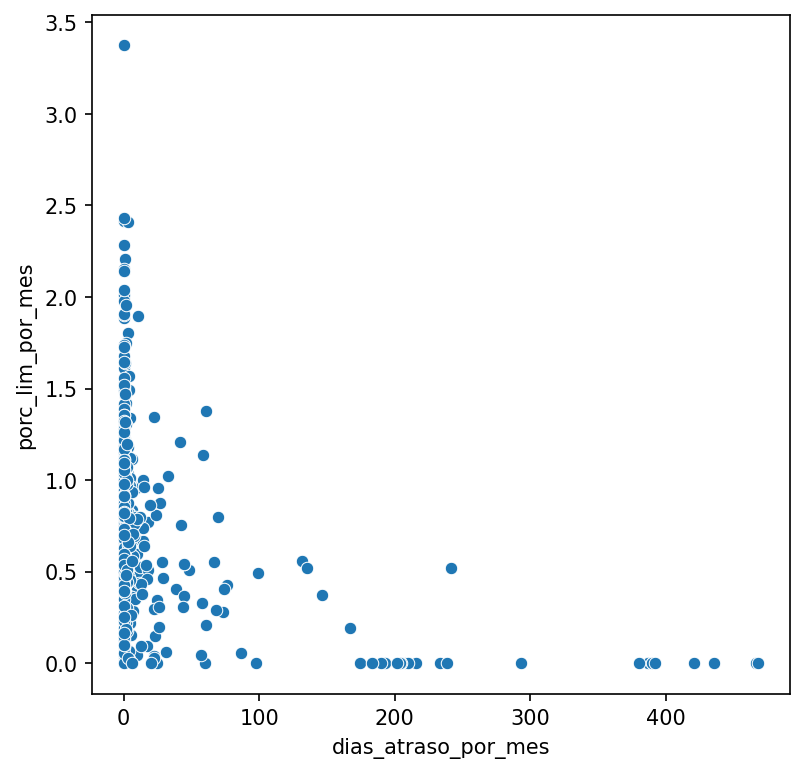

In [37]:
plt.figure(figsize=(6,6),dpi=150)
sns.scatterplot(data=df_all,x='dias_atraso_por_mes',y='porc_lim_por_mes');

Se busca maximizar el valor en Y y minimizar el valor en X. Se ve que hay muchos clientes que en media usan más del límite mensual (_Y > 1_), y también lo pagan a tiempo o con poco atraso. A todos estos clientes se puede considerar otorgarles incrementos en sus créditos. A los clientes que no usan mucho el crédito, no tendría sentido incrementarlo. Para los clientes que tal vez usen mucho un mes, y no tanto en otro mes, y en la media el valor Y es menos de 1, puede ser interesante incrementar el crédito como motivación para su uso en ciertos períodos del año.

Para cuantificar el análisis cualitativo hecho en el párrafo anterior, primero consideramos el porcentaje utilizado del límite a cada mes. Como tenemos el desvío de este valor, vamos a hacer un primer filtro considerando solo los casos donde la suma del límite más del desvio _standard_ es más grande que 1, o sea, nos quedamos solo con los clientes que llegaron a utilizar más de 100% del límite en algún mes del pasado, en algun momento.

In [38]:
mask_lim = ( df_all.porc_lim_por_mes+df_all.porc_lim_por_mes_dev ) > 1
print("Numero de datos antes de la máscara: ",len(df_all))
df_all_lim = df_all[mask_lim]
print("Numero de datos después de la máscara: ",len(df_all_lim))

Numero de datos antes de la máscara:  571
Numero de datos después de la máscara:  338


Considerando estos casos, analicemos ahora el tiempo medio en que se paga la deuda:

In [39]:
df_all_lim.dias_atraso_por_mes.describe(percentiles=np.arange(0,1,0.05))

count    338.000000
mean       4.140506
std       13.553839
min        0.000000
0%         0.000000
5%         0.000000
10%        0.000000
15%        0.000000
20%        0.000000
25%        0.000000
30%        0.000000
35%        0.124632
40%        0.247059
45%        0.364474
50%        0.620192
55%        0.877574
60%        1.113889
65%        1.506818
70%        1.908182
75%        2.455263
80%        3.153333
85%        4.285000
90%        7.066667
95%       18.372955
max      135.176471
Name: dias_atraso_por_mes, dtype: float64

Vemos que en 90% de los casos, la deuda fue pagada entre 0 (sin atrado) y 7 días, en media. Para el 10% restante hay un salto grande para mucho más de 1 semana. Nos quedamos con este umbral de 7 días (valor que puede ser modificado), y generamos la lista de clientes a otorgar más crédito:

In [40]:
mejores_clientes = df_all_lim[df_all_lim.dias_atraso_por_mes < 7].index

Exportamos a un archivo la lista con los IDs de mejores clientes.

In [41]:
list_out = mejores_clientes.astype('str')
with open('Mejores_Clientes_ID.txt','w') as fileout:
    for item in list_out:
        fileout.write('%s\n' % item)

Ahora creamos una nueva columna en el dataset original con la información positiva (1) o negativa (0) para un otorgamiento de crédito más grande.

In [42]:
df_all["Otorgar_mas"] = (df_all.index.isin(mejores_clientes)).astype('uint8')

In [43]:
df_all.Otorgar_mas.sum()

303

Son 303 los clientes que se sugiere otorgar un mayor crédito, considerando que lo usaran mucho y lo pagaran en un tiempo razonable.

Por último, creamos también una otra columna, conteniendo los clientes que no usan todo el crédito (50% del límite de crédito o más), pero si lo pagan en menos de 1 semana, lo que correspondería a clientes que deberían tener crédito (y lo tienen). Esta información será importante para la segunda parte del trabajo.

In [44]:
mask_lim_otorgar = df_all.porc_lim_por_mes > 0.5
df_all_lim_otorgar = df_all[mask_lim_otorgar]
credito_clientes = df_all_lim_otorgar[df_all_lim_otorgar.dias_atraso_por_mes < 7].index
df_all["Otorgar"] = (df_all.index.isin(credito_clientes)).astype('uint8')

La columna "Otorgar", por lo tanto, corresponde a los clientes que usan suficientemente bastante del crédito otorgado y lo pagan en un tiempo razonable, y van a servir como referéncia para determinar futuros potenciales clientes que no tienen crédito.

# Objetivo 2: Qué clientes sin crédito son potencialmente buenos candidatos para tenerlo

En el paso anterior, determinamos cuáles clientes son mejores para recibir un mayor crédito, y, posteriormente, los buenos clientes que tienen crédito, lo usan (por lo menos en parte, y lo pagan en tiempo. El segundo objetivo es buscar saber, de los clientes que no tienen crédito, a cuál se podría otorgarlo. Por lo tanto, la idea es primero entender qué características pueden estar relacionadas con el otorgamento. Para esto, vamos montar un modelo simple de _machine learning_ que asocia determinadas _features_ a el otorgamento o no de crédito (la columna "Otorgar").

Porque vamos analisar ahora los clientes que no tienen crédito, tenemos que considerar _features_ que no estan asociadas a crédito o deuda. Se elejieran las siguientes características:

In [45]:
df = df_all[['total_compras','n_compras_medio','n_sucursales_medio','subcanal',
             'meses_cliente','Otorgar']].copy()
print(len(df))

571


Es importante notar que tenemos menos de 600 puntos, y por esto no podemos considerar demasiadas _features_. Averiguando si el dataset está desbalanceado.

In [46]:
df.Otorgar.value_counts(normalize=True)

1    0.577933
0    0.422067
Name: Otorgar, dtype: float64

Nuestro dataset no está muy desbalanceado, con 58% de los casos donde se otorga crédito contra 42% a los que no. Calculemos las correlaciones entre las columnas:

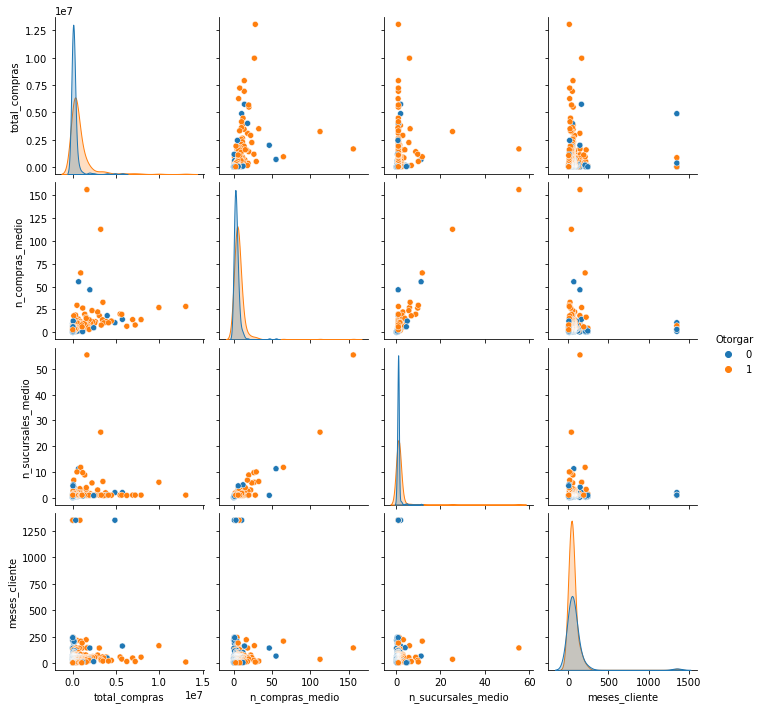

In [47]:
sns.pairplot(df,hue='Otorgar');

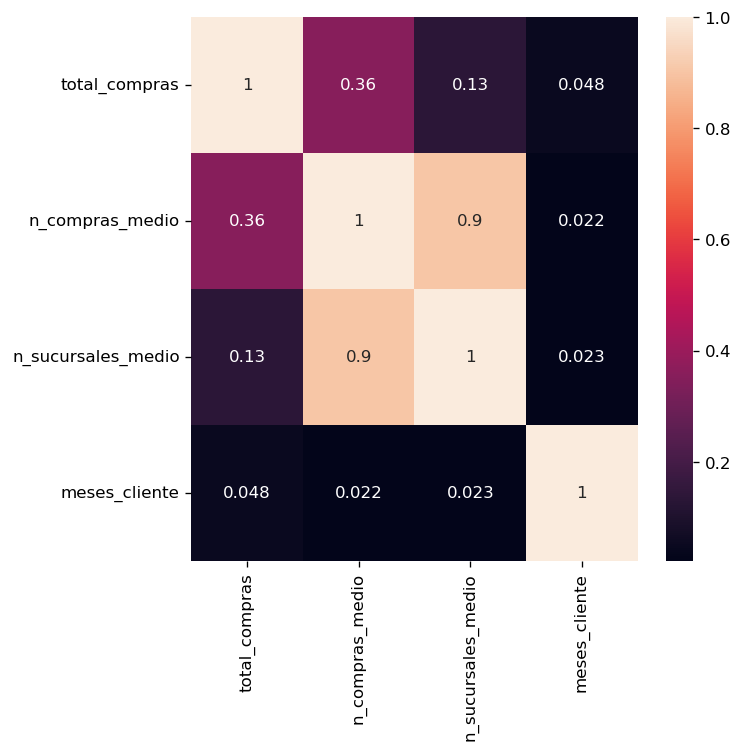

In [48]:
plt.figure(figsize=(6,6),dpi=120)
sns.heatmap(df.drop(columns='Otorgar').corr(),annot=True);

Se puede ver que hay una certa división espacial entro las observaciones positivas y negativas, lo que es bueno. Además, no hay tanta correlación entre las variables, excepto el número medio de compras y sucursales, lo que tiene sentido considerando que cuanto más sucursales tenés, más compras vas a hacer. Abandonemos la columna de las sucursales y empecemos a modelar.

In [49]:
df.drop(columns='n_sucursales_medio',inplace=True)

In [50]:
from sklearn.metrics import confusion_matrix,f1_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from xgboost.sklearn import XGBClassifier

import warnings
warnings.filterwarnings(action="ignore", message=r'.*Use subset.*of np.ndarray is not recommended')

In [51]:
df=pd.get_dummies(df)
df=df.drop(columns='subcanal_D') # Como tenemos 4 columnas dummies, 1 es reduntante

In [52]:
X=df.drop(columns=['Otorgar'])
y=df.Otorgar

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1, stratify=y)

In [54]:
myscale = StandardScaler()
X_train = myscale.fit_transform(X_train)
X_test = myscale.transform(X_test)

Se probaran muchos modelos distintos: _KNN_, _Naive-Bayes_, _Decision-Tree_, _Random Forest_, y _XGBOOST_. Las _performances_ no fueran muy distintas, y vamos a mostrar el análisis hecho por _XGBOOST_.

In [55]:
cv = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)

params = {  
    'max_depth': [3,4,5,6],
    'n_estimators': [100,150,200],
    'learning_rate': [0.01,0.02,0.05],
}

xgb = XGBClassifier(n_jobs=-1,use_label_encoder=False,eval_metric='logloss')
xgb_cv = GridSearchCV(xgb, param_grid=params, cv=cv, verbose=1, n_jobs=-1,scoring='roc_auc')
xgb_cv.fit(X_train,y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     eval_metric='logloss', gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_chi...
                                     n_estimators=100, n_jobs=-1,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                             

In [56]:
results=pd.DataFrame(xgb_cv.cv_results_)
results[['params','mean_test_score','std_test_score']]

,params,mean_test_score,std_test_score
0,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",0.833548,0.029469
1,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",0.835913,0.030745
2,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",0.839496,0.033818
3,"{'learning_rate': 0.01, 'max_depth': 4, 'n_est...",0.834144,0.027391
4,"{'learning_rate': 0.01, 'max_depth': 4, 'n_est...",0.835573,0.024592
5,"{'learning_rate': 0.01, 'max_depth': 4, 'n_est...",0.839926,0.027764
6,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",0.834259,0.030860
7,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",0.835675,0.026481
8,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",0.835403,0.024967
9,"{'learning_rate': 0.01, 'max_depth': 6, 'n_est...",0.829758,0.030764


El desvío _standard_ entre los distintos _splits_ es un poco alto, porque tenemos pocas observaciones, y el pequeño gaño en precisión es, en general, más chico que este error. Por lo tanto, la precisión de grande parte de estes hiperparámetros es bastante parecida. El hecho que tenemos pocas observaciones complican un poco la busca de mejores hiperparámetros. Quedamos con 200 árboles chicos con profundidad de 4, con una tasa de aprendizaje lenta (0.01).

In [57]:
xgb = XGBClassifier(max_depth=4,n_estimators=100,learning_rate=0.015,
                    n_jobs=-1,use_label_encoder=False,eval_metric='logloss')
xgb.fit(X_train,y_train)
print("Accuracy (entrenamento): ",xgb.score(X_train,y_train))
print("Accuracy (testeo): ",xgb.score(X_test,y_test))

Accuracy (entrenamento):  0.8247663551401869
Accuracy (testeo):  0.7762237762237763


Tenemos una precisión de aproximadamente 78%, lo que está bueno. Miremos la importancia de las _features_.

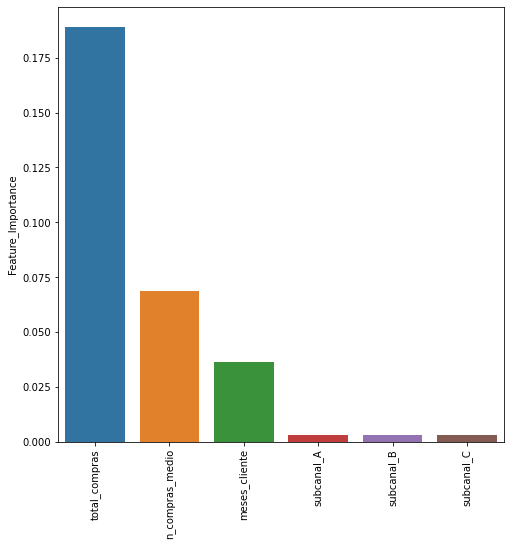

In [58]:
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(xgb, X_test,y_test)
feat_imp = pd.DataFrame(perm_importance.importances_mean,index=X.columns,columns=['Feature_Importance'])
feat_imp = feat_imp.sort_values(by='Feature_Importance',ascending=False)

plt.figure(figsize=(8,8))
sns.barplot(data=feat_imp,x=feat_imp.index,y='Feature_Importance')
plt.xticks(rotation=90);

Vemos que la _feature_ más importante es el total que el cliente gastó en compras, seguido por el numero medio de compras durante el mes y su _edad_ (desde cuándo es cliente). El subcanal es casi irrelevante. Por lo tanto, cuanto más gasta un cliente, cuanto más sucursales tiene y más "viejo" es, más grande la chance de ser un buen cliente en términos de tener y usar crédito.

### Derivando el dataset con todos los clientes

Ahora que tenemos nuestro modelo de _Machine Learning_, podemos aplicarlo sobre los datos del dataset completo, con todos los clientes que no tienen crédito. Pero para esto necesitamos primero armarlo, generando las mismas _features_ y haciendo el mismo scaling.

Empezamos del dataset con las transacciones, y sacamos las características que no son relevantes para el modelo de _Machine Learning_.

In [59]:
df_red = df_tr.drop(columns=['compras_contado','compras_credito','mes'])

In [60]:
df_allclients_info = df_red.groupby(by='id_cliente').agg( { 'compras_total':'sum','n_compras_total':'mean'})
df_allclients_info.columns = ['total_compras','n_compras_medio']

In [61]:
df_allclients_info=df_allclients_info.merge(df_c, left_index=True,right_index=True,how='left')

In [62]:
df_allclients_info

,total_compras,n_compras_medio,subcanal,meses_cliente
id_cliente,,,,
3823,0.00,0.000000,C,213
5813,0.00,0.000000,C,213
5999,132811.76,8.454545,C,213
8425,803613.35,12.272727,B,262
9993,1272938.85,11.272727,D,289
...,...,...,...,...
1930591,1088694.20,5.909091,A,192
1978155,0.00,0.000000,C,187
1979465,0.00,0.000000,C,182


Sacando los clientes que ya tienen crédito.

In [63]:
lista_clientes_con_credito = X.index
df_allclients_info=df_allclients_info[~df_allclients_info.index.isin(lista_clientes_con_credito)].copy()

Siguiendo los mismos pasos de antes.

In [64]:
X_allclients=pd.get_dummies(df_allclients_info)
X_allclients=X_allclients.drop(columns='subcanal_D') # Como tenemos 4 columnas dummies, 1 es reduntante

In [65]:
X_allclients=myscale.transform(X_allclients)

Ahora usamos nuestro modelo previamente optimizado para predecir de todos los clientes cuáles deberían tener crédito otorgado.

In [66]:
df_allclients_info['Otorgar'] = xgb.predict(X_allclients)

In [67]:
df_allclients_info

,total_compras,n_compras_medio,subcanal,meses_cliente,Otorgar
id_cliente,,,,,
3823,0.00,0.000000,C,213,0
5813,0.00,0.000000,C,213,0
5999,132811.76,8.454545,C,213,1
8425,803613.35,12.272727,B,262,1
9993,1272938.85,11.272727,D,289,1
...,...,...,...,...,...
1916223,4474.61,0.409091,C,203,0
1978155,0.00,0.000000,C,187,0
1979465,0.00,0.000000,C,182,0


In [68]:
print(df_allclients_info.Otorgar.sum())

375


De los casi 42000 clientes sin crédito, solamente a 375 se daría un crédito, lo que es un número un poco más grande que los 303 clientes elegidos para tener otorgado un mayor crédito.

Por último, exportamos a un archivo los clientes previstos a tener un mejor comportamiento en caso de que un crédito sea dado.

In [69]:
potencial_mejores_clientes = df_allclients_info[df_allclients_info.Otorgar == 1].index
list_out = potencial_mejores_clientes.astype('str')
with open('Clientes_a_ganar_credito_ID.txt','w') as fileout:
    for item in list_out:
        fileout.write('%s\n' % item)

# Conclusiones

Usando los 4 datasets proporcionados, determinamos primeramente cuáles son los mejores clientes para tener otorgado un mayor crédito. Los parámetros utilizados para determinar esto fueron el volumen de uso del límite que ya poseen y también la cantidad de días que están en mora. Vimos que a más o menos 50% de los clientes se podía otorgar créditos mayores, y se creó un archivo "Mejores_Clientes_ID.txt" con esta lista clientes.

Usando esta información en un modelo simple de Machine Learning, hicimos una predicción de cuáles clientes, de los que no tienen crédito, que son buenos potenciales a ganar uno. Vimos que de la gran lista de 42000 clientes sin crédito, solamente a 375 se podría dar de acuerdo con el modelo. La precisión de la predicción es de 78%, lo que es razonable. Esta otra lista fue salva en el archivo "Clientes_a_ganar_credito_ID.txt".

# Consideraciones generales

El challenge fue muy interesante, y naturalmente me hubiera gustado haber hecho más. Yo analizé las variables que me parecían más importantes, pero no logré hacer un análisis exhaustivo. Por ejemplo, no llegué a usar el monto de la deuda, que puede también ser importante, y tampoco logré, con el tiempo que tenía a mi disposición, explorar los plazos. Además, hay más de una forma de determinar si un cliente es bueno o no. De hecho, la elección de los umbrales "1 semana de atraso medio" y "50% de uso del crédito" no son matemáticamente precisas, pero falta conocimiento de dominio para hacer una elección más educada de estos parámetros.

Me pareció curioso que algunos clientes no tenían registro de ninguna compra, y que no hayan registros de mora/límites de clientes que si usaran crédito. Esto complicó un poco el análisis del problema.

Me quedo a disposición para futuros esclarecimientos, discusiones o charlas caso sea de interés. Gracias por la oportunidad.